In [1]:
from __future__ import print_function

import os
import argparse
import socket
import time
import sys

import torch
import torch.optim as optim
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader

from models import model_pool
from models.util import create_model

from dataset.mini_imagenet import ImageNet, MetaImageNet
# from dataset.mnist import MNIST, MetaMNIST
from dataset.cifar import CIFAR100, MetaCIFAR100
from dataset.sofar import SOFAR, MetaSOFAR
from dataset.transform_cfg import transforms_options, transforms_list

from util import adjust_learning_rate, accuracy, AverageMeter
from eval.meta_eval import meta_test
from eval.cls_eval import validate

from torchvision import transforms

In [2]:
print(torch.__version__)

1.7.0


In [3]:
parser = argparse.ArgumentParser('argument for training')

parser.add_argument('--eval_freq', type=int, default=10, help='meta-eval frequency')
parser.add_argument('--print_freq', type=int, default=100, help='print frequency')
parser.add_argument('--tb_freq', type=int, default=500, help='tb frequency')
parser.add_argument('--save_freq', type=int, default=10, help='save frequency')
parser.add_argument('--batch_size', type=int, default=4, help='batch_size')
parser.add_argument('--num_workers', type=int, default=8, help='num of workers to use')
parser.add_argument('--epochs', type=int, default=200, help='number of training epochs')

# optimization
parser.add_argument('--learning_rate', type=float, default=0.001, help='learning rate')
parser.add_argument('--lr_decay_epochs', type=str, default='60,80', help='where to decay lr, can be a list')
parser.add_argument('--lr_decay_rate', type=float, default=0.1, help='decay rate for learning rate')
parser.add_argument('--weight_decay', type=float, default=5e-4, help='weight decay')
parser.add_argument('--momentum', type=float, default=0.9, help='momentum')
parser.add_argument('--adam', action='store_true', help='use adam optimizer')

# dataset
parser.add_argument('--model', type=str, default='resnet50', choices=model_pool)
parser.add_argument('--dataset', type=str, default='SOFAR', choices=['miniImageNet', 'tieredImageNet',
                                                                                'CIFAR-FS', 'FC100'])
parser.add_argument('--transform', type=str, default='A', choices=transforms_list)
parser.add_argument('--use_trainval', action='store_true', help='use trainval set')

# cosine annealing
parser.add_argument('--cosine', action='store_true', help='using cosine annealing')

# specify folder
parser.add_argument('--model_path', type=str, default='', help='path to save model')
parser.add_argument('--tb_path', type=str, default='', help='path to tensorboard')
parser.add_argument('--data_root', type=str, default='', help='path to data root')

# meta setting
parser.add_argument('--n_test_runs', type=int, default=600, metavar='N',help='Number of test runs')
parser.add_argument('--n_ways', type=int, default=2, metavar='N',help='Number of classes for doing each classification run')
parser.add_argument('--n_shots', type=int, default=1, metavar='N', help='Number of shots in test')
parser.add_argument('--n_queries', type=int, default=15, metavar='N',help='Number of query in test')
parser.add_argument('--n_aug_support_samples', default=5, type=int,help='The number of augmented samples for each meta test sample')
parser.add_argument('--test_batch_size', type=int, default=1, metavar='test_batch_size',help='Size of test batch)')
parser.add_argument('-t', '--trial', type=str, default='1', help='the experiment id')

opt = parser.parse_args(args=[])

In [4]:
if opt.dataset == 'CIFAR-FS' or opt.dataset == 'FC100':
    opt.transform = 'D'

if opt.use_trainval:
    opt.trial = opt.trial + '_trainval'

# set the path according to the environment
if not opt.model_path:
    opt.model_path = './models_pretrained'
if not opt.tb_path:
    opt.tb_path = './tensorboard'
if not opt.data_root:
    opt.data_root = '../../datasets/{}'.format(opt.dataset)
else:
    opt.data_root = '{}/{}'.format(opt.data_root, opt.dataset)
opt.data_aug = True

In [5]:
iterations = opt.lr_decay_epochs.split(',')
opt.lr_decay_epochs = list([])
for it in iterations:
    opt.lr_decay_epochs.append(int(it))
opt.model_name = '{}_{}_lr_{}_decay_{}_trans_{}'.format(opt.model, opt.dataset, opt.learning_rate,opt.weight_decay, opt.transform)

if opt.cosine:
    opt.model_name = '{}_cosine'.format(opt.model_name)

if opt.adam:
    opt.model_name = '{}_useAdam'.format(opt.model_name)

opt.model_name = '{}_trial_{}'.format(opt.model_name, opt.trial)

opt.n_gpu = torch.cuda.device_count()

In [5]:
# get datasets
opt.data_root = '../../datasets/sofar_v3/'
train_partition = 'train'

train_loader = DataLoader(SOFAR(opt.data_root, data_aug=True, partition=train_partition, transform=None),
                                  batch_size=opt.batch_size, shuffle=True, drop_last=True,
                                  num_workers=opt.num_workers)
val_loader = DataLoader(SOFAR(opt.data_root, data_aug=True, partition='train', transform=None),
                                batch_size=opt.batch_size // 2, shuffle=False, drop_last=False,
                                num_workers=opt.num_workers // 2)
n_cls = 11

4400
>> iteration : 0
>> iteration : 50
>> iteration : 100
>> iteration : 150
>> iteration : 200
>> iteration : 250
>> iteration : 300
>> iteration : 350
>> iteration : 400
>> iteration : 450
>> iteration : 500
>> iteration : 550
>> iteration : 600
>> iteration : 650
>> iteration : 700
>> iteration : 750
>> iteration : 800
>> iteration : 850
>> iteration : 900
>> iteration : 950
>> iteration : 1000
>> iteration : 1050
>> iteration : 1100
>> iteration : 1150
>> iteration : 1200
>> iteration : 1250
>> iteration : 1300
>> iteration : 1350
>> iteration : 1400
>> iteration : 1450
>> iteration : 1500
>> iteration : 1550
>> iteration : 1600
>> iteration : 1650
>> iteration : 1700
>> iteration : 1750
>> iteration : 1800
>> iteration : 1850
>> iteration : 1900
>> iteration : 1950
>> iteration : 2000
>> iteration : 2050
>> iteration : 2100
>> iteration : 2150
>> iteration : 2200
>> iteration : 2250
>> iteration : 2300
>> iteration : 2350
>> iteration : 2400
>> iteration : 2450
>> iteration : 250

In [6]:
# model
model = create_model(opt.model, n_cls, opt.dataset)

print(f'>> model name : {opt.model}, dataset : {opt.dataset}')

>> model name : resnet50, dataset : SOFAR


In [8]:
# optimizer
if opt.adam:
    optimizer = torch.optim.Adam(model.parameters(),lr=opt.learning_rate,weight_decay=0.0005)
else:
    optimizer = optim.SGD(model.parameters(),lr=opt.learning_rate,momentum=opt.momentum,weight_decay=opt.weight_decay)

criterion = nn.CrossEntropyLoss()

if torch.cuda.is_available():
    if opt.n_gpu > 1:
        model = nn.DataParallel(model)
    model = model.cuda()
    criterion = criterion.cuda()
    cudnn.benchmark = True

In [9]:
# set cosine annealing scheduler
if opt.cosine:
    eta_min = opt.learning_rate * (opt.lr_decay_rate ** 3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, opt.epochs, eta_min, -1)

In [10]:
def accuracy(predictions, targets):
    predictions = predictions.argmax(dim=1).view(targets.shape)
    return (predictions == targets).sum().float() / targets.size(0)

In [11]:
def train(epoch, train_loader, model, criterion, optimizer, opt):
    """One epoch training"""
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    acc1 = AverageMeter()
    total = 0
    correct = 0

    end = time.time()
    for idx, (input, target) in enumerate(train_loader):
        data_time.update(time.time() - end)

        input = input.float()
        if torch.cuda.is_available():
            input = input.cuda()
            target = target.cuda()

        # ===================forward=====================
        output = model(input)
        loss = criterion(output, target)
        
        acc = accuracy(output, target)
        losses.update(loss.item(), input.size(0))
        acc1.update(acc.item(), input.size(0))

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        batch_time.update(time.time() - end)
        end = time.time()

        # tensorboard logger
        pass

        # print info
        if idx % opt.print_freq == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc@1 {top1.val:.3f} ({top1.avg:.3f})\t'.format(
                   epoch, idx, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses, top1=acc1))
            sys.stdout.flush()

    print(' * Acc@1 {top1.avg:.3f}='.format(top1=acc1))

    return acc1.avg, losses.avg

In [ ]:
best_acc = 0.0

for epoch in range(1, opt.epochs + 1):
    if opt.cosine:
        scheduler.step()
    else:
        adjust_learning_rate(epoch, opt, optimizer)
    print("==> training...")

    time1 = time.time()
    train_acc, train_loss = train(epoch, train_loader, model, criterion, optimizer, opt)
    time2 = time.time()
    print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

    print('train_acc', train_acc, epoch)
    print('train_loss', train_loss, epoch)

    test_acc, test_loss = validate(val_loader, model, criterion, opt)

    print(f'[epoch {epoch}] test_acc : {test_acc}')
    print(f'[epoch {epoch}] test_loss : {test_loss}')

    # regular saving
    if best_acc < test_acc :
        best_acc = test_acc
        print('==> Saving...')
        save_file = os.path.join('./checkpoint/best_model_sofar.pth'.format(epoch=epoch))
        torch.save(model.state_dict(), save_file)

In [ ]:
print('Complete ...')

## Test phase

In [6]:
# checkpoint model path check
model_nm = 'multi'


if model_nm == 'imagenet' : 
    n_cls = 11
    model = create_model(opt.model, n_cls, opt.dataset)
    model = model.cuda()
    print('Experiment with Imagenet weight frozen')
elif model_nm == 'multi' :
    n_cls = 11
    #model_path = './checkpoint/ckpt_epoch_198.pth' # multi class classification
    model_path = './checkpoint/best_model_sofar.pth' # Distill multi class classification
    model = create_model(opt.model, n_cls, opt.dataset)
    ckpt = torch.load(model_path)
    corrected_dict = { k.replace('features.', ''): v for k, v in ckpt.items() } 
    model.load_state_dict(corrected_dict, strict = False)
    model = model.cuda()
    print(f'>> model name : {opt.model}, model_path : {model_path}')

>> model name : resnet50, model_path : ./checkpoint/best_model_sofar.pth


In [15]:
# check test datasets
dataset_nm = 'sofar_test2' # choose : [cifarfs, miniImagenet, mnist]

train_trans, test_trans = transforms_options[opt.transform]

if dataset_nm == 'cifarfs' :
    opt.data_root = '../../datasets/CIFAR-FS'
    meta_testloader = DataLoader(MetaCIFAR100(args=opt, partition='test',
                                                  train_transform=train_trans,
                                                  test_transform=test_trans),
                                     batch_size=opt.test_batch_size, shuffle=False, drop_last=False,
                                     num_workers=opt.num_workers)
elif dataset_nm == 'miniImagenet' :
    train_trans, test_trans = transforms_options['A']
    opt.data_root = '../../datasets/miniImageNet/'
    meta_testloader = DataLoader(MetaImageNet(args=opt, partition='test',
                                                  train_transform=train_trans,
                                                  test_transform=test_trans),
                                     batch_size=opt.test_batch_size, shuffle=False, drop_last=False,
                                     num_workers=opt.num_workers)
# elif dataset_nm == 'mnist' :
#     # double MNIST (for few shot learning)
#     opt.transfomr = 'A'
#     train_trans, test_trans = transforms_options['A']
#     opt.data_root = '../../datasets/double_mnist'
#     meta_testloader = DataLoader(MetaMNIST(args=opt, partition='test',
#                                                   train_transform=train_trans,
#                                                   test_transform=test_trans),
#                                      batch_size=opt.test_batch_size, shuffle=False, drop_last=False,
#                                      num_workers=opt.num_workers)
elif dataset_nm == 'sofar_test2' :
    opt.data_root = '../../datasets/sanitized_test2_v2/'
    meta_testloader = DataLoader(MetaSOFAR(args=opt, partition='test',
                                                  train_transform=None,
                                                  test_transform=None),
                                     batch_size=opt.test_batch_size, shuffle=False, drop_last=False,
                                     num_workers=opt.num_workers)
else : 
    raise NotImplementedError

400
>> iteration : 0
>> iteration : 50
>> iteration : 100
>> iteration : 150
>> iteration : 200
>> iteration : 250
>> iteration : 300
>> iteration : 350
Get data dictionary


In [16]:
# eval
test_acc, test_std = meta_test(model, meta_testloader)
print(f'Test Accuracy : {test_acc}, Test Std : {test_std}')

0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()
/opt/conda/lib/python3.7/site-packages/torchvision/transforms/functional.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a

Test Accuracy : 0.5034444444444446, Test Std : 0.007219981553113744


In [8]:
train_trans, test_trans = transforms_options[opt.transform]
opt.data_root = '../../datasets/sofar_v3'
sofar_test_loader = DataLoader(SOFAR(opt.data_root, data_aug=True, partition='test', transform=None),
                                  batch_size=opt.batch_size, shuffle=True, drop_last=True,
                                  num_workers=opt.num_workers)

model.eval()
sofar_test_output = list()
for idx, (input, target) in enumerate(sofar_test_loader) :
    input = input.float().cuda()
    target = target.cuda()
    
    with torch.no_grad():
        output = model(input)
        
    sofar_test_output.append(output)

944
>> iteration : 0
>> iteration : 50
>> iteration : 100
>> iteration : 150
>> iteration : 200
>> iteration : 250
>> iteration : 300
>> iteration : 350
>> iteration : 400
>> iteration : 450
>> iteration : 500
>> iteration : 550
>> iteration : 600
>> iteration : 650
>> iteration : 700
>> iteration : 750
>> iteration : 800
>> iteration : 850
>> iteration : 900
Get data dictionary


In [70]:
## test v2 set
model.eval()
opt.data_root = '../../datasets/sanitized_test2_v2/'
test2_loader = DataLoader(SOFAR(opt.data_root, data_aug=True, partition='test', transform=None),
                                  batch_size=opt.batch_size, shuffle=True, drop_last=True,
                                  num_workers=opt.num_workers)
test2_output = list()
for idx, (input, target) in enumerate(test2_loader) :
    input = input.float().cuda()
    target = target.cuda()
    
    with torch.no_grad():
        output = model(input)
        
    test2_output.append(output)

400
>> iteration : 0
>> iteration : 50
>> iteration : 100
>> iteration : 150
>> iteration : 200
>> iteration : 250
>> iteration : 300
>> iteration : 350
Get data dictionary


In [11]:
## test v3 set 
opt.data_root = '../../datasets/sanitized_test3_v1/'
test3_loader = DataLoader(SOFAR(opt.data_root, data_aug=True, partition='test', transform=None),
                                  batch_size=opt.batch_size, shuffle=True, drop_last=True,
                                  num_workers=opt.num_workers)

model.eval()
test3_output = list()
for idx, (input, target) in enumerate(test3_loader) :
    input = input.float().cuda()
    target = target.cuda()
    
    with torch.no_grad():
        output = model(input)
        
    test3_output.append(output)

299
>> iteration : 0
>> iteration : 50
>> iteration : 100
>> iteration : 150
>> iteration : 200
>> iteration : 250
Get data dictionary


In [52]:
# model output을 하나의 prob값으로 변경해서 저장헤야 함
sofar_test_prob_list = list()

for i in range(len(sofar_test_output)) :
    for j in range(len(sofar_test_output[i].max(dim=1).values)) : 
        tmp = sofar_test_output[i].max(dim=1).values[j].item()
        sofar_test_prob_list.append(tmp)

In [71]:
test2_prob_list = list()

for i in range(len(test2_output)) :
    for j in range(len(test2_output[i].max(dim=1).values)) : 
        tmp = test2_output[i].max(dim=1).values[j].item()
        test2_prob_list.append(tmp)

In [55]:
test3_prob_list = list()

for i in range(len(test3_output)) :
    for j in range(len(test3_output[i].max(dim=1).values)) : 
        tmp = test3_output[i].max(dim=1).values[j].item()
        test3_prob_list.append(tmp)

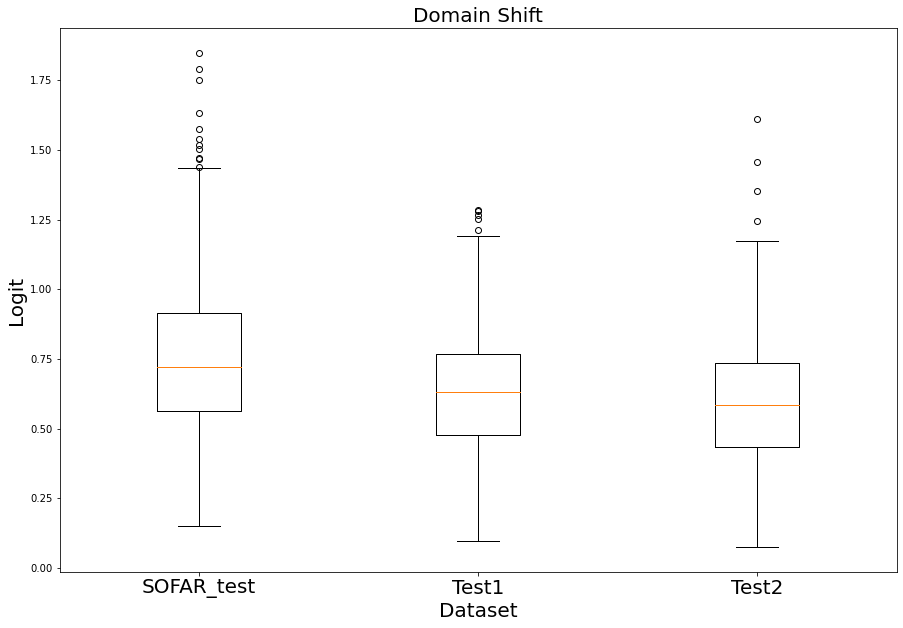

In [73]:
### boxplot으로 확인
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (15, 10))
ax.boxplot([sofar_test_prob_list, test2_prob_list, test3_prob_list])

plt.title('Domain Shift', fontsize=20)
plt.xticks([1, 2, 3], ['SOFAR_test', 'Test1', 'Test2'], fontsize = 20)
plt.xlabel('Dataset', fontsize = 20)
plt.ylabel('Logit', fontsize = 20)

plt.show()